In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pickle
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
import seaborn as sns

ModuleNotFoundError: No module named 'cv2'

In [4]:
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)

    image = image.convert('L')

    image = image.resize((256, 256))

    image = image.point(lambda x: x / 255.0)

    image = np.asarray(image)

    return image

In [5]:
def load_dataset(directory):
    images_list = []

    if os.path.isdir(directory):
        for image_file in os.listdir(directory):
            image_path = os.path.join(directory, image_file)

            image = load_and_preprocess_image(image_path)

            images_list.append(image)

    images = np.array(images_list)

    return images

In [6]:
train_normal_dir = r'chest_xray\train\NORMAL'
train_pneumonia_dir = r'chest_xray\train\PNEUMONIA'
train_normal_images = load_dataset(train_normal_dir)
train_pneumonia_images = load_dataset(train_pneumonia_dir)
print('Pneumonia Images',  train_pneumonia_images.shape)
print('Normal Images',  train_normal_images.shape)

Pneumonia Images (3875, 256, 256)
Normal Images (1341, 256, 256)


In [7]:
val_normal_dir = r'chest_xray\val\NORMAL'
val_pneumonia_dir = r'chest_xray\val\PNEUMONIA'
val_normal_images = load_dataset(val_normal_dir)
val_pneumonia_images = load_dataset(val_pneumonia_dir)
print('Pneumonia Images',  val_pneumonia_images.shape)
print('Normal Images',  val_normal_images.shape)

Pneumonia Images (8, 256, 256)
Normal Images (8, 256, 256)


In [8]:
test_normal_dir = r'chest_xray\test\NORMAL'
test_pneumonia_dir = r'chest_xray\test\PNEUMONIA'
test_normal_images = load_dataset(test_normal_dir)
test_pneumonia_images = load_dataset(test_pneumonia_dir)
print('Pneumonia Images',  test_pneumonia_images.shape)
print('Normal Images',  test_normal_images.shape)

Pneumonia Images (390, 256, 256)
Normal Images (234, 256, 256)


In [20]:
def create_class_labels(data_path):
    class_labels = []
    class_folders = sorted(os.listdir(data_path))

    for class_folder in class_folders:
        class_path = os.path.join(data_path, class_folder)
        if os.path.isdir(class_path):
            if class_folder.lower() == 'normal':
                label = 0
            elif class_folder.lower() == 'pneumonia':
                label = 1

            image_files = os.listdir(class_path)

            class_labels.extend([(os.path.join(class_path, image), label) for image in image_files])

    return class_labels

In [21]:
train_data_path = "chest_xray/train"
val_data_path = "chest_xray/val"
test_data_path = "chest_xray/test"

train_class_labels = create_class_labels(train_data_path)
val_class_labels = create_class_labels(val_data_path)
test_class_labels = create_class_labels(test_data_path)

In [22]:
np.random.shuffle(train_class_labels)
np.random.shuffle(val_class_labels)
np.random.shuffle(test_class_labels)

In [23]:
train_image_paths, train_labels = zip(*train_class_labels)
val_image_paths, val_labels = zip(*val_class_labels)
test_image_paths, test_labels = zip(*test_class_labels)

In [24]:
train_images = np.array([load_and_preprocess_image(image_path) for image_path in train_image_paths])
val_images = np.array([load_and_preprocess_image(image_path) for image_path in val_image_paths])
test_images = np.array([load_and_preprocess_image(image_path) for image_path in test_image_paths])

In [25]:
train_images = train_images.reshape(train_images.shape + (1,))
val_images = val_images.reshape(val_images.shape + (1,))
test_images = test_images.reshape(test_images.shape + (1,))

In [26]:
combined_train_images = np.concatenate((train_images, val_images), axis=0)
combined_train_labels = np.concatenate((train_labels, val_labels), axis=0)

combined_indices = np.arange(combined_train_images.shape[0])
np.random.shuffle(combined_indices)

combined_train_images = combined_train_images[combined_indices]
combined_train_labels = combined_train_labels[combined_indices]

In [27]:
split_index = int(0.8 * combined_train_images.shape[0])

train_images = combined_train_images[:split_index]
train_labels = combined_train_labels[:split_index]

val_images = combined_train_images[split_index:]
val_labels = combined_train_labels[split_index:]

In [28]:
print(val_images.shape)
print(val_labels.shape)
print(train_images.shape)
print(train_labels.shape)

(1047, 256, 256, 1)
(1047,)
(4185, 256, 256, 1)
(4185,)


In [29]:
datagen_training = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
augmented_data_gen_train_normal = datagen_training.flow(train_images, train_labels, batch_size=32, shuffle=True)

In [20]:
epochs = 10
steps_per_epoch = len(train_images) // 32

for epoch in range(epochs):
    model.fit(
        augmented_data_gen_train_normal,
        epochs=1,
        steps_per_epoch=steps_per_epoch
    )

130/130 [==============================] - 169s 1s/step - loss: 0.2879 - accuracy: 0.9006


In [21]:
datagen_validation = ImageDataGenerator()

validation_data_gen = datagen_validation.flow(val_images, val_labels, batch_size=32, shuffle=False)

val_loss, val_accuracy = model.evaluate(validation_data_gen)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

33/33 [==============================] - 11s 328ms/step - loss: 0.2514 - accuracy: 0.9064
Validation Loss: 0.2514, Validation Accuracy: 0.9064


Epoch 1/10
130/130 [==============================] - 175s 1s/step - loss: 0.2739 - accuracy: 0.9078 - val_loss: 0.1920 - val_accuracy: 0.9389
Epoch 2/10
130/130 [==============================] - 173s 1s/step - loss: 0.2603 - accuracy: 0.9121 - val_loss: 0.2251 - val_accuracy: 0.9131
Epoch 3/10
130/130 [==============================] - 173s 1s/step - loss: 0.3012 - accuracy: 0.8810 - val_loss: 0.1768 - val_accuracy: 0.9312
Epoch 4/10
130/130 [==============================] - 172s 1s/step - loss: 0.2365 - accuracy: 0.9114 - val_loss: 0.1749 - val_accuracy: 0.9236
Epoch 5/10
130/130 [==============================] - 173s 1s/step - loss: 0.2203 - accuracy: 0.9181 - val_loss: 0.1773 - val_accuracy: 0.9245
Epoch 6/10
130/130 [==============================] - 173s 1s/step - loss: 0.2364 - accuracy: 0.9148 - val_loss: 0.1778 - val_accuracy: 0.9217
Epoch 7/10
130/130 [==============================] - 173s 1s/step - loss: 0.2303 - accuracy: 0.9213 - val_loss: 0.1995 - val_accuracy: 0.9074

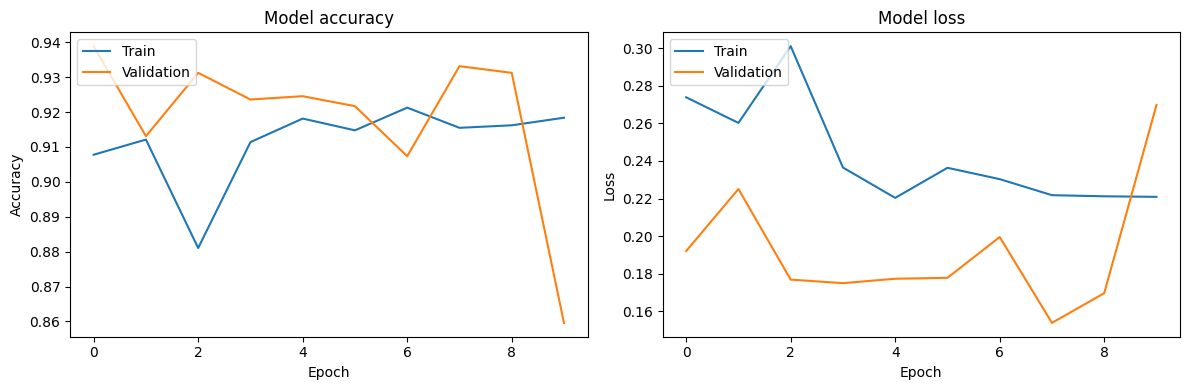

In [22]:
history = model.fit(
    augmented_data_gen_train_normal,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data_gen
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [23]:
model.save('model.keras', save_format='tf', include_optimizer=True)

In [24]:
with open('variables.pkl', 'wb') as file:
    pickle.dump((
        train_images, val_images, test_images, train_labels, 
        val_labels, test_labels, train_image_paths, val_image_paths, 
        test_image_paths, val_loss, val_accuracy), file
    )

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model("model.keras")

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score

datagen_testing = ImageDataGenerator()
test_data_gen = datagen_testing.flow(test_images, test_labels, batch_size=len(test_images), shuffle=False)
steps = len(test_data_gen)
predictions = model.predict(test_data_gen, steps=steps)

predicted_labels = (predictions > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test Accuracy: {accuracy:.4f}')

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Test Sensitivity (True Positive Rate): {sensitivity:.4f}')

specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Test Specificity (True Negative Rate): {specificity:.4f}')

NameError: name 'ImageDataGenerator' is not defined

### Retraining CNN model with parameters adjusted.

In [26]:
datagen_training = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

In [36]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'), 
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
def lr_schedule(epoch):
    return 0.001 if epoch < 10 else 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)

total_epochs = 10
steps_per_epoch = len(train_images) // 32

model.fit(
    augmented_data_gen_train_normal,
    epochs=total_epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_scheduler]
)

Epoch 1/10
130/130 [==============================] - 151s 1s/step - loss: 0.4594 - accuracy: 0.7840 - lr: 0.0010
Epoch 2/10
130/130 [==============================] - 153s 1s/step - loss: 0.3522 - accuracy: 0.8490 - lr: 0.0010
Epoch 3/10
130/130 [==============================] - 154s 1s/step - loss: 0.3242 - accuracy: 0.8688 - lr: 0.0010
Epoch 4/10
130/130 [==============================] - 154s 1s/step - loss: 0.2821 - accuracy: 0.8847 - lr: 0.0010
Epoch 5/10
130/130 [==============================] - 155s 1s/step - loss: 0.2756 - accuracy: 0.8904 - lr: 0.0010
Epoch 6/10
130/130 [==============================] - 155s 1s/step - loss: 0.2710 - accuracy: 0.8941 - lr: 0.0010
Epoch 7/10
130/130 [==============================] - 155s 1s/step - loss: 0.2526 - accuracy: 0.8972 - lr: 0.0010
Epoch 8/10
130/130 [==============================] - 155s 1s/step - loss: 0.2573 - accuracy: 0.8984 - lr: 0.0010
Epoch 9/10
130/130 [==============================] - 155s 1s/step - loss: 0.2411 - accu

In [36]:
model = load_model('model.keras')

In [37]:
datagen_validation = ImageDataGenerator()

validation_data_gen = datagen_validation.flow(val_images, val_labels, batch_size=16, shuffle=False)

val_loss, val_accuracy = model.evaluate(validation_data_gen)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

66/66 [==============================] - 12s 185ms/step - loss: 0.2938 - accuracy: 0.8443
Validation Loss: 0.2938, Validation Accuracy: 0.8443


Epoch 1/10
130/130 [==============================] - 161s 1s/step - loss: 0.2263 - accuracy: 0.9176 - val_loss: 0.1498 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 2/10
130/130 [==============================] - 160s 1s/step - loss: 0.2162 - accuracy: 0.9119 - val_loss: 0.1738 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 3/10
130/130 [==============================] - 157s 1s/step - loss: 0.2135 - accuracy: 0.9229 - val_loss: 0.2171 - val_accuracy: 0.9074 - lr: 0.0010
Epoch 4/10
130/130 [==============================] - 161s 1s/step - loss: 0.2185 - accuracy: 0.9160 - val_loss: 0.1504 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 5/10
130/130 [==============================] - 170s 1s/step - loss: 0.2215 - accuracy: 0.9181 - val_loss: 0.1430 - val_accuracy: 0.9360 - lr: 0.0010
Epoch 6/10
130/130 [==============================] - 180s 1s/step - loss: 0.2057 - accuracy: 0.9245 - val_loss: 0.1178 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 7/10
130/130 [==============================] - 187s 1s/st

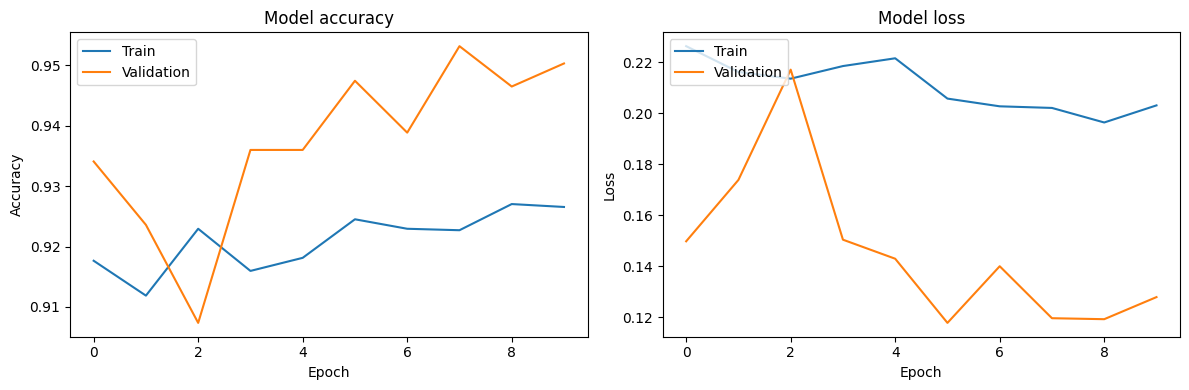

In [40]:
history = model.fit(
    augmented_data_gen_train_normal,
    epochs=total_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data_gen,
    callbacks=[lr_scheduler]
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [42]:
model.save('model1.keras', save_format='tf', include_optimizer=True)

In [75]:
test_images.shape

(624, 256, 256, 1)

In [90]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_loss, test_accuracy = model.evaluate(test_images, test_labels)

20/20 [==============================] - 6s 275ms/step - loss: 5.9763 - accuracy: 0.6250


In [1]:
model = load_model('model1.keras')

In [2]:
with open('variables.pkl', 'rb') as file:
    (
        train_images, val_images, test_images, train_labels, 
        val_labels, test_labels, train_image_paths, val_image_paths, 
        test_image_paths, val_loss, val_accuracy
    ) = pickle.load(file)

In [5]:
test_labels = np.array(test_labels)

1/1 [==============================] - 8s 8s/step


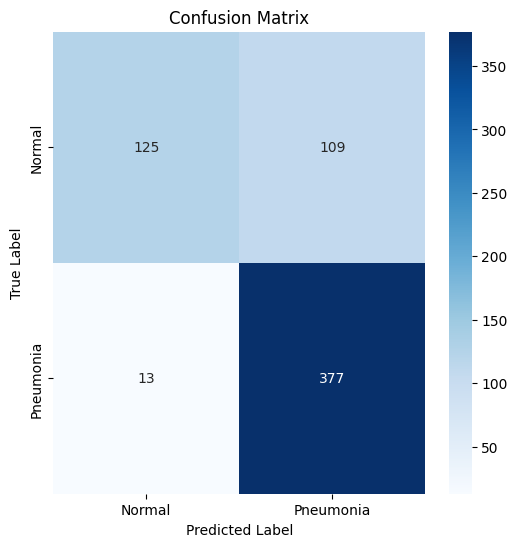

Test Accuracy: 0.8045


In [14]:
datagen_testing = ImageDataGenerator()

test_data_gen = datagen_testing.flow(test_images, test_labels, batch_size=len(test_images), shuffle=False)

steps = len(test_data_gen)

predictions = model.predict(test_data_gen, steps=steps)

predicted_labels = (predictions > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

print(f'Test Accuracy: {accuracy:.4f}')

In [30]:
model1 = load_model('model1.keras')

In [31]:
from keras.losses import hinge

model1.compile(loss=hinge, optimizer='adam', metrics=['accuracy'])

In [32]:
model1.fit(
    train_images, 
    train_labels,
    epochs=10, 
    batch_size=16, 
    validation_data=(val_images, val_labels)
)

Epoch 1/10
262/262 [==============================] - 206s 781ms/step - loss: 0.3377 - accuracy: 0.9352 - val_loss: 0.3174 - val_accuracy: 0.9389
Epoch 2/10
262/262 [==============================] - 203s 777ms/step - loss: 0.3197 - accuracy: 0.9544 - val_loss: 0.3010 - val_accuracy: 0.9580
Epoch 3/10
262/262 [==============================] - 220s 842ms/step - loss: 0.3145 - accuracy: 0.9591 - val_loss: 0.3004 - val_accuracy: 0.9589
Epoch 4/10
262/262 [==============================] - 214s 817ms/step - loss: 0.3069 - accuracy: 0.9654 - val_loss: 0.3008 - val_accuracy: 0.9551
Epoch 5/10
262/262 [==============================] - 203s 774ms/step - loss: 0.3019 - accuracy: 0.9701 - val_loss: 0.2932 - val_accuracy: 0.9637
Epoch 6/10
262/262 [==============================] - 199s 760ms/step - loss: 0.2985 - accuracy: 0.9720 - val_loss: 0.2943 - val_accuracy: 0.9608
Epoch 7/10
262/262 [==============================] - 201s 768ms/step - loss: 0.2926 - accuracy: 0.9780 - val_loss: 0.2924 -

In [38]:
total_epochs = 10
steps_per_epoch = 2 * len(train_images) // 32

def lr_schedule(epoch):
    return 0.001 if epoch < 10 else 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule)

history = model1.fit(
    train_images,
    train_labels,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_data_gen,
    callbacks=[lr_scheduler]
)

Epoch 1/10
261/261 [==============================] - 226s 866ms/step - loss: 0.2862 - accuracy: 0.9812 - val_loss: 0.2934 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 2/10
261/261 [==============================] - 226s 864ms/step - loss: 0.2844 - accuracy: 0.9781 - val_loss: 0.2941 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 3/10
261/261 [==============================] - 216s 826ms/step - loss: 0.2849 - accuracy: 0.9803 - val_loss: 0.2915 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 4/10
261/261 [==============================] - 206s 789ms/step - loss: 0.2832 - accuracy: 0.9842 - val_loss: 0.2969 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 5/10
261/261 [==============================] - 212s 812ms/step - loss: 0.2765 - accuracy: 0.9833 - val_loss: 0.2918 - val_accuracy: 0.9647 - lr: 0.0010
Epoch 6/10
261/261 [==============================] - 219s 838ms/step - loss: 0.2773 - accuracy: 0.9891 - val_loss: 0.2919 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 7/10
261/261 [==========================

In [39]:
model1.save("updatedModel.keras")

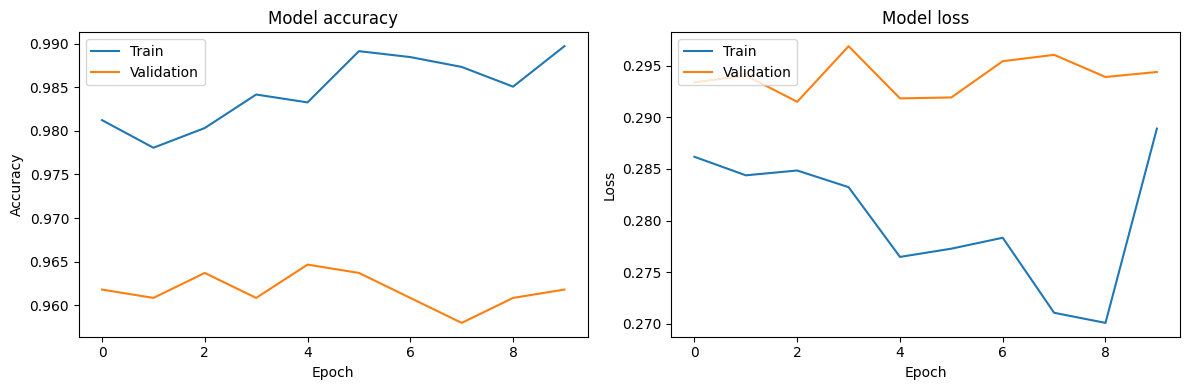

In [40]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score

datagen_testing = ImageDataGenerator()

test_data_gen = datagen_testing.flow(test_images, test_labels, batch_size=len(test_images), shuffle=False)

steps = len(test_data_gen)

predictions = model.predict(test_data_gen, steps=steps)

predicted_labels = (predictions > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(test_labels, predicted_labels)

print(f'Test Accuracy: {accuracy:.4f}')

: 

: 

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model("updatedModel.keras")

In [3]:
import pickle

with open('variables.pkl', 'rb') as file:
    (
        train_images, val_images, test_images, train_labels, 
        val_labels, test_labels, train_image_paths, val_image_paths, 
        test_image_paths, val_loss, val_accuracy
    ) = pickle.load(file)

1/1 [==============================] - 7s 7s/step


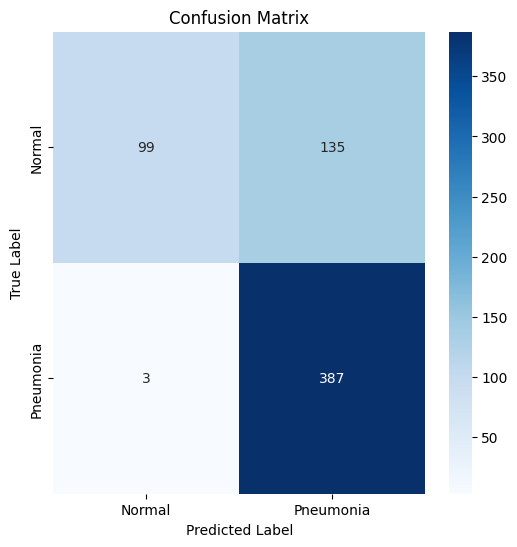

Test Accuracy: 0.7788
Test Sensitivity (True Positive Rate): 0.9923
Test Specificity (True Negative Rate): 0.4231


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score

datagen_testing = ImageDataGenerator()
test_data_gen = datagen_testing.flow(test_images, test_labels, batch_size=len(test_images), shuffle=False)
steps = len(test_data_gen)
predictions = model.predict(test_data_gen, steps=steps)

predicted_labels = (predictions > 0.5).astype(int).flatten()

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Test Accuracy: {accuracy:.4f}')

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print(f'Test Sensitivity (True Positive Rate): {sensitivity:.4f}')

specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'Test Specificity (True Negative Rate): {specificity:.4f}')

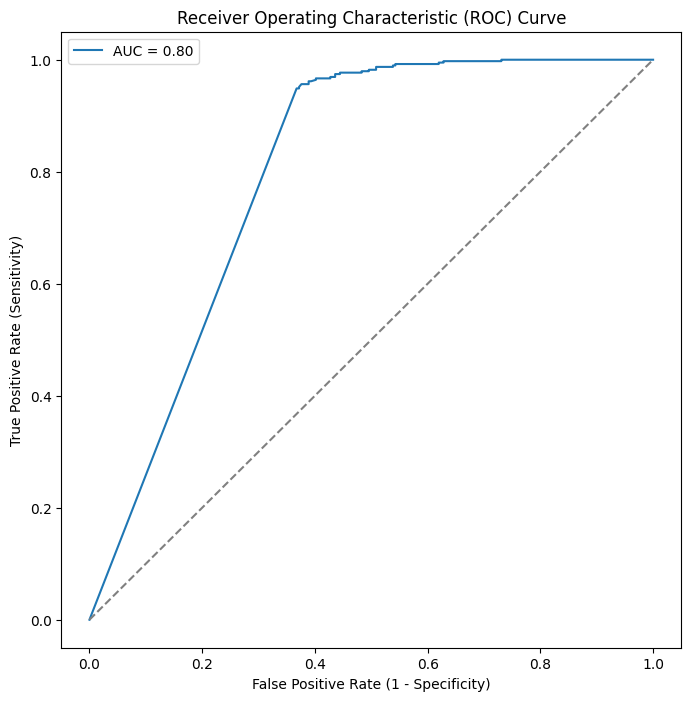

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming 'predictions' contains the model's predicted probabilities
fpr, tpr, thresholds = roc_curve(test_labels, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(test_labels, predictions):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [11]:
import tensorflow as tf

model = tf.keras.models.load_model('updatedModel.keras')

import pickle

with open('variables.pkl', 'rb') as file:
    (
        train_images, val_images, test_images, train_labels, 
        val_labels, test_labels, train_image_paths, val_image_paths, 
        test_image_paths, val_loss, val_accuracy
    ) = pickle.load(file)

In [12]:
prediction = model.predict('chest_xray/test/NORMAL/IM-0022-0001.jpeg')

IndexError: tuple index out of range